In [1]:
import numpy as np
import pandas as pd
from darts import TimeSeries,concatenate
from darts.models import TSMixerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
from captum.attr import IntegratedGradients, NoiseTunnel
import json
import matplotlib.pyplot as plt

In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [3]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [6]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TSMixerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=79,
        output_chunk_length=15,
        hidden_size=32,
        ff_size=63, 
        n_epochs=100,
        batch_size=24,
        norm_type="LayerNorm",
        normalize_before=True,
        num_blocks=1,
        activation="ReLU",
        dropout=0.3,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,    
        show_warnings=True,
        force_reset=True, # Importante para que cada iteração treine do zero com este model_name
        optimizer_kwargs={"lr": 3.60e-3, "weight_decay": 1e-5},
    )

    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | HuberLoss        | 0      | train
1 | train_criterion     | HuberLoss        | 0      | train
2 | val_criterion       | HuberLoss        | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 1.2 K  | train
6 | feature_mixing_hist | _FeatureMixing   | 4.4 K  | train
7 | conditional_mixer   | ModuleList       | 6.3 K  | train
8 | fc_out              | Linear           | 264    | train
-----------------------------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.049     Total estimated mo


Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.039


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.033


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.028. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | HuberLoss        | 0      | train
1 | train_crit

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...            R2      SMAPE
Temperature                    3.742383    1.934524  ...  9.270694e-01   7.582460
Precipitation_accumulated      0.006060    0.077849  ... -5.824105e+06   2.568004
Humidity                      44.046676    6.636767  ...  8.621254e-01  11.806196
Wind_Speed_kmh                 0.325157    0.570225  ...  4.692857e-01  32.737102
Soil_Moisture              76091.291019  275.846499  ...  6.883991e-01   2.663280
Soil_Temperature              12.644814    3.555955  ...  8.365589e-01  10.102997
Wind_Dir_Sin                   0.188777    0.434485  ...  4.786542e-01  77.427837
Wind_Dir_Cos                   0.178657    0.422678  ...  7.032296e-01  60.557859

[8 rows x 5 columns]
O R2 desse fold foi -728012.545500924

Fold 2

Treinando o modelo...
Train set: 2081 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 12.087


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.034 >= min_delta = 0.001. New best score: 11.053


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.714 >= min_delta = 0.001. New best score: 10.339


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.544 >= min_delta = 0.001. New best score: 9.794


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.136 >= min_delta = 0.001. New best score: 9.658


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.426 >= min_delta = 0.001. New best score: 9.232


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.542 >= min_delta = 0.001. New best score: 8.691


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.428 >= min_delta = 0.001. New best score: 8.263


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.494 >= min_delta = 0.001. New best score: 7.769


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.440 >= min_delta = 0.001. New best score: 7.329


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.442 >= min_delta = 0.001. New best score: 6.887


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 6.874


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.159 >= min_delta = 0.001. New best score: 6.715


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.133 >= min_delta = 0.001. New best score: 6.582


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 6.575


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 6.535


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 6.509


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.319 >= min_delta = 0.001. New best score: 6.189


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.244 >= min_delta = 0.001. New best score: 5.945


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 5.942


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 5.888


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 5.847


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 5.801


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.267 >= min_delta = 0.001. New best score: 5.534


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 5.523


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.146 >= min_delta = 0.001. New best score: 5.377


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.131 >= min_delta = 0.001. New best score: 5.246


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.112 >= min_delta = 0.001. New best score: 5.135


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.131 >= min_delta = 0.001. New best score: 5.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 5.004. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | HuberLoss        | 0      | train
1 | train_crit

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...        R2       SMAPE
Temperature                    2.622518    1.619419  ...  0.927064    9.294837
Precipitation_accumulated      0.043323    0.208142  ...  0.961394    3.242065
Humidity                      31.503669    5.612813  ...  0.897182    6.251920
Wind_Speed_kmh                 0.194154    0.440629  ...  0.527063   43.611749
Soil_Moisture              34648.670701  186.141534  ...  0.958448    1.602414
Soil_Temperature               2.829882    1.682225  ...  0.938408    9.568894
Wind_Dir_Sin                   0.199362    0.446499  ...  0.426924  101.822010
Wind_Dir_Cos                   0.127759    0.357434  ...  0.588261   49.932653

[8 rows x 5 columns]
O R2 desse fold foi 0.7780928986228963

Fold 3

Treinando o modelo...
Train set: 3119 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | HuberLoss        | 0      | train
1 | train_crit

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...            R2       SMAPE
Temperature                    4.737941    2.176681  ...      0.823344   10.206361
Precipitation_accumulated    650.240171   25.499807  ... -25798.938663    5.676731
Humidity                      18.803555    4.336307  ...      0.754383    4.089298
Wind_Speed_kmh                 0.037069    0.192532  ...      0.451175  177.584399
Soil_Moisture              48592.470311  220.436999  ...      0.738448    2.548593
Soil_Temperature               5.680716    2.383425  ...      0.801878   11.870326
Wind_Dir_Sin                   0.022056    0.148514  ...      0.745601  176.060012
Wind_Dir_Cos                   0.062409    0.249819  ...      0.705683   32.057763

[8 rows x 5 columns]
O R2 desse fold foi -3224.239768978055

Fold 4

Treinando o modelo...
Train set: 4157 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Docum

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE  ...            R2       SMAPE
Temperature                   0.542011   0.736214  ...  8.354700e-01    4.017301
Precipitation_accumulated    15.629603   3.953429  ... -2.850438e+05    0.760353
Humidity                      2.742265   1.655979  ...  7.705092e-01    1.375974
Wind_Speed_kmh                0.007002   0.083675  ...          -inf  200.000000
Soil_Moisture              3017.900109  54.935418  ... -1.223295e+00    0.741901
Soil_Temperature              0.628652   0.792876  ...  8.022474e-01    4.902175
Wind_Dir_Sin                  0.002900   0.053847  ...          -inf  200.000000
Wind_Dir_Cos                  0.000633   0.025165  ...          -inf    2.105967

[8 rows x 5 columns]
O R2 desse fold foi -inf

Fold 5

Treinando o modelo...
Train set: 5195 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Docum

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE  ...          R2       SMAPE
Temperature                   1.541376   1.241522  ...   -1.602769   11.494735
Precipitation_accumulated    32.230499   5.677191  ... -981.364561    0.995422
Humidity                      3.880413   1.969876  ...    0.593280    1.830793
Wind_Speed_kmh                0.008788   0.093745  ...        -inf  200.000000
Soil_Moisture              2850.387313  53.389019  ...    0.923088    0.645477
Soil_Temperature              0.651809   0.807347  ...   -1.668173    7.039557
Wind_Dir_Sin                  0.002326   0.048227  ...        -inf  200.000000
Wind_Dir_Cos                  0.006359   0.079741  ...        -inf    7.471012

[8 rows x 5 columns]
O R2 desse fold foi -inf

Fold 6

Treinando o modelo...
Train set: 6233 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | HuberLoss        | 0      | train
1 | train_crit

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE  ...          R2       SMAPE
Temperature                   0.418987   0.647292  ...    0.836282    6.769077
Precipitation_accumulated    85.588164   9.251387  ... -352.098730    1.905305
Humidity                      6.731797   2.594571  ...    0.865977    2.585200
Wind_Speed_kmh                0.009050   0.095133  ...   -4.377485  190.948577
Soil_Moisture              6264.305753  79.147367  ...    0.544934    1.066136
Soil_Temperature              0.960119   0.979857  ...    0.466777   10.539657
Wind_Dir_Sin                  0.008829   0.093962  ...    0.814709  179.843246
Wind_Dir_Cos                  0.014460   0.120249  ...    0.800556   16.587048

[8 rows x 5 columns]
O R2 desse fold foi -44.01837257292522

Fold 7

Treinando o modelo...
Train set: 7271 samples
Validation set: 1038 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...         R2       SMAPE
Temperature                    1.007588    1.003787  ...   0.861007   23.377113
Precipitation_accumulated     36.488857    6.040601  ... -16.421206    1.176963
Humidity                      10.306315    3.210345  ...   0.909533    2.743614
Wind_Speed_kmh                 0.411975    0.641853  ...   0.694951  117.813420
Soil_Moisture              18268.079341  135.159459  ...   0.989790    1.381859
Soil_Temperature               0.989437    0.994704  ...   0.812282   22.653483
Wind_Dir_Sin                   0.188084    0.433687  ...   0.503580  106.409149
Wind_Dir_Cos                   0.189882    0.435755  ...   0.626328   89.572839

[8 rows x 5 columns]
O R2 desse fold foi -1.3779668706308654
O melhor fold foi 2


In [7]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TSMixerModel(output_chunk_shift=0, hidden_size=32, ff_size=63, num_blocks=1, activation=ReLU, dropout=0.3, norm_type=LayerNorm, normalize_before=True, use_static_covariates=True, model_name=model_2, input_chunk_length=79, output_chunk_length=15, n_epochs=100, batch_size=24, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fed273947d0>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0036, 'weight_decay': 1e-05})

In [8]:
s = scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
forecasts_t = scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


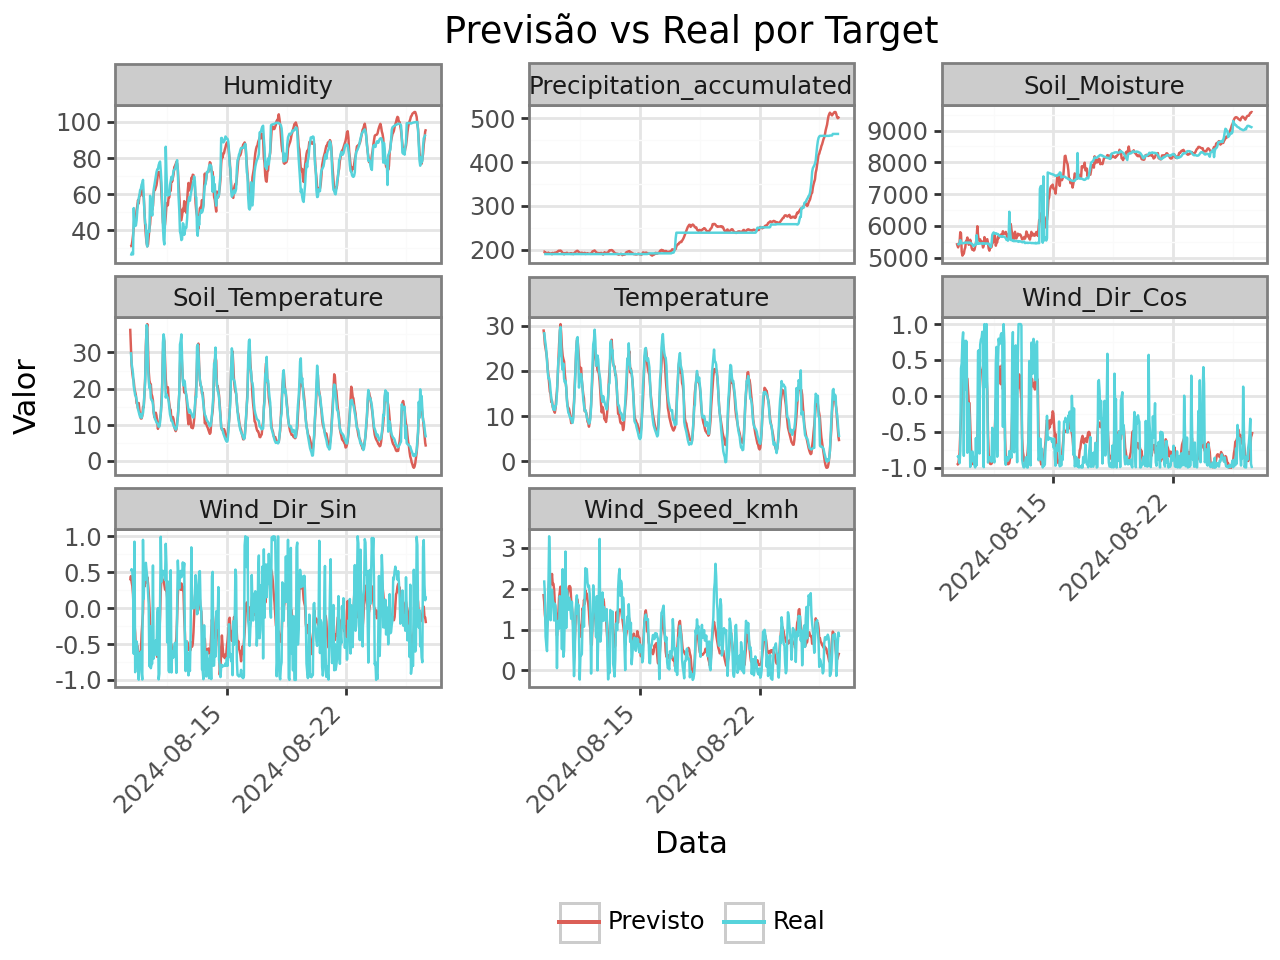

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [10]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

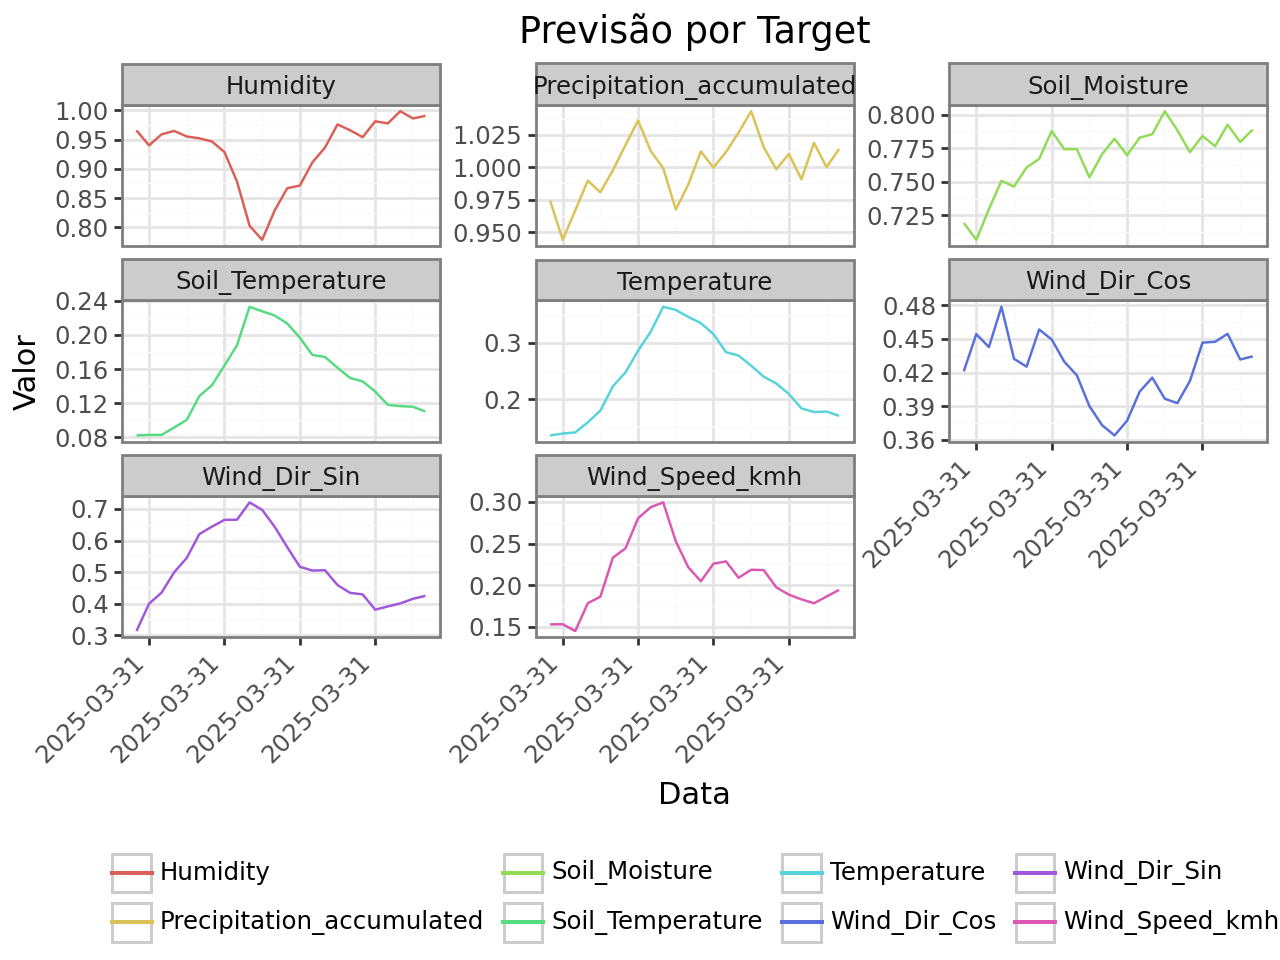

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [11]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [12]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

In [13]:
# prepara série-alvo e covariáveis
tgt_arr = best_val_scaled[0].values()
encoder_values = model.generate_fit_encodings(best_train_scaled)
cov_arr = encoder_values[0][0].values()  # use seu objeto de covariáveis reais

params = next(model.model.parameters())
dtype, device = params.dtype, params.device

tgt = torch.tensor(tgt_arr, dtype=dtype, device=device).unsqueeze(0)
cov = torch.tensor(cov_arr, dtype=dtype, device=device).unsqueeze(0)

full_input = torch.cat([tgt, cov], dim=2)
full_input.requires_grad_(True)
baseline = torch.zeros_like(full_input)

def forward_fn(x):
    preds,_ = model.model((x, None))
    return preds[:, -1, 0]

ig = IntegratedGradients(forward_fn)
attrs, delta = ig.attribute(
    inputs=full_input,
    baselines=baseline,
    return_convergence_delta=True
)
ig_vals = attrs.detach().cpu().numpy()[0].sum(axis=0)
print("IG importâncias:", ig_vals, "δ=", delta)

nt = NoiseTunnel(ig)
nt_attrs = nt.attribute(
    inputs=full_input,
    baselines=baseline,
    nt_type='smoothgrad',
    nt_samples=10,
    stdevs=0.02
)
nt_vals = nt_attrs.detach().cpu().numpy()[0].sum(axis=0)
print("NT importâncias:", nt_vals)


ValueError: not enough values to unpack (expected 3, got 2)

In [36]:
target_names = best_val_scaled[0].columns.tolist()
covar_names  = encoder_values[0][0].columns.tolist()
feature_names = target_names + covar_names

# monta DataFrame
df = pd.DataFrame({
    "feature": feature_names,
    "IG": ig_vals,
    "NT": nt_vals,
}).melt(id_vars="feature", var_name="method", value_name="importance")

plot = (
    ggplot(df, aes(x="feature", y="importance", fill="method"))
    + geom_col(position="dodge")
    + coord_flip()                          # faz o flip para ficar horizontal
    + labs(x="Feature", y="Importância", fill="Método",
           title="Importância de Features pelo IG e NT")
    + theme_bw()
)

plot.show()
plot.save('importancia_features.png', width=12, height=10, dpi=300)

NameError: name 'ig_vals' is not defined